In [144]:
import os
os.chdir("/home/jakob/doktor/projects/EnsembleUncertainty/code")
"""Learing "logit" distribution in regression example"""
import logging
import zipfile
from copy import copy, deepcopy
import urllib.request
from pathlib import Path
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Optimizer
from torch.optim.sgd import SGD
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.model_selection import KFold
from src.dataloaders.uci import uci_base, wine, bost
from src import metrics
from src import utils
from src.ensemble import simple_regressor, ensemble
from src.distilled import logits_probability_distribution, niw_probability_distribution
from src import loss as custom_loss
import matplotlib.pyplot as plt
import tikzplotlib

# Settings
class Args():
    pass
args = Args()
args.seed = 1
args.gpu = True
args.log_dir = Path("./logs")
args.log_level = logging.INFO
args.retrain = True
args.num_ensemble_members=1
args.num_epochs=1
args.lr = 0.01




LOGGER = logging.getLogger(__name__)
EXPERIMENT_NAME = "red_regression_logits"

log_file = Path("{}_{}.log".format(
    EXPERIMENT_NAME,
    datetime.now().strftime("%Y%m%d_%H%M%S")))
utils.setup_logger(log_path=Path.cwd() / args.log_dir / log_file,
                   log_level=args.log_level)

# General constructs
train_metrics = list()
test_metrics = list()

rmse = metrics.Metric(name="RMSE", function=metrics.root_mean_squared_error)
train_metrics.append(deepcopy(rmse))
test_metrics.append(rmse)

BATCH_SIZE = 32
torch.cuda.device(0)
torch.cuda.get_device_name(torch.cuda.current_device())
device = torch.device("cuda")
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

2020-02-16 19:15:17,768 INFO  root            - Log at /home/jakob/doktor/projects/EnsembleUncertainty/code/logs/red_regression_logits_20200216_191517.log
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        if not v.is_cuda and cuda:
            v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

def get_loss_and_rmse(network,
                      loss_function,
                      x, y,
                      mean_shift=None, std_scale=None):
    x, y = to_variable(var=(x, y), cuda=True)

    logits = network.forward(x)
    output = network.transform_logits(logits)
    mean, std = output

    if mean_shift is not None and std_scale is not None:
        mean_shift = torch.tensor(mean_shift).float().cuda()
        std_scale = torch.tensor(std_scale).float().cuda()
        mean = mean * std_scale + mean_shift
        y = y * std_scale + mean_shift
        std *= std_scale

    loss = loss_function((mean, std), y)

    rmse = ((mean - y)**2).mean()**0.5

    return loss.detach().cpu(), rmse.detach().cpu()

def create_ensemble(num_ensemble_members,
                    input_dim,
                    num_hidden,
                    lr,
                    ensemble_output_size):
    prob_ensemble = ensemble.Ensemble(ensemble_output_size)
    for _ in range(num_ensemble_members):
        network = simple_regressor.Model(layer_sizes=[input_dim,
                                                      num_hidden,
                                                      ensemble_output_size],
                                 device=device,
                                 variance_transform=utils.variance_linear_asymptote(),
                                 loss_function=custom_loss.gaussian_neg_log_likelihood_1d)
        network.optimizer = torch.optim.Adam(network.parameters(),
                                    lr=lr)
        prob_ensemble.add_member(network)
    return prob_ensemble

def mean_and_std_from_list(samples):
    """Calculate mean and std from np-array compatible list"""
    array = np.array(samples)
    return array.mean(), array.std()

def mean_and_std_from_metric(metric, rescale=1):
    """Calculate mean and std from np-array compatible list"""
    return metric.mean() * rescale, metric.std() * rescale

# UCI datasets

In [3]:
def train_mc_dropout(data,
                     num_ensemble_members,
                     num_epochs,
                     num_units,
                     learn_rate,
                     weight_decay,
                     train_metrics,
                     test_metrics,
                     batch_size):
    
    train_nll, test_nll = [], []
    train_rmses, test_rmses = [], []
    for metric in train_metrics:
        metric.reset()        
        
    for metric in test_metrics:
        metric.reset()
    
    prob_ensemble = create_ensemble(num_ensemble_members=num_ensemble_members,
                                    input_dim=data.input_dim,
                                    num_hidden=num_units,
                                    lr=learn_rate,
                                    ensemble_output_size=2)
    prob_ensemble.add_metrics(train_metrics)

    x_train, y_train, x_test, y_test = data.create_train_val_split(0.9)

    x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
    y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

    x_train = (x_train - x_means) / x_stds
    y_train = (y_train - y_means) / y_stds

    x_test = (x_test - x_means) / x_stds
    y_test = (y_test - y_means) / y_stds
    
    if batch_size is None:
        batch_size = x_train.shape[0]
    trainloader = uci_base.uci_dataloader(x_train, y_train, batch_size)

    losses = []
    prob_ensemble.train(train_loader=trainloader,
                        num_epochs=num_epochs)

    mean_shift = None
    std_scale = None
    #mean_shift = y_means
    #std_scale = y_stds

    network = prob_ensemble.members[0]
    testloader = uci_base.uci_dataloader(x_test, y_test, len(y_test))
    for metric in train_metrics:
        metric.reset()
    train_metrics, train_loss = network.test(trainloader,
                                             train_metrics,
                                             network.loss)
    test_metrics, test_loss = network.test(testloader,
                                           test_metrics,
                                           network.loss)
    
    train_nll.append((train_loss.item() + np.log(y_stds)[0]))
    test_nll.append((test_loss.item() + np.log(y_stds)[0]))

    print("Train NLL\t = {:.3f} +/- {:.3f}".format(*mean_and_std_from_list(train_nll)))
    print("Test  NLL\t = {:.3f} +/- {:.3f}".format(*mean_and_std_from_list(test_nll)))
    print("Train RMSE\t = {:.3f} +/- {:.3f}".format(
        *mean_and_std_from_metric(train_metrics[0], rescale=y_stds[0])))
    print("Test RMSE\t = {:.3f} +/- {:.3f}".format(
        *mean_and_std_from_metric(test_metrics[0], rescale=y_stds[0])))
    return prob_ensemble

# Red wine dataset

In [4]:
wine_data = wine.WineData("data/uci/wine/winequality-red.csv")
prob_ensemble = train_mc_dropout(data=wine_data,
                       num_ensemble_members=10,
                       num_epochs=40,
                       num_units=50,
                       learn_rate=1e-1,
                       weight_decay=0.0, #1e-1/len(data)**0.5,
                       train_metrics=train_metrics,
                       test_metrics=test_metrics,
                       batch_size=None)

2020-02-14 08:41:27,522 INFO  Model           - Moving model to device: cuda
2020-02-14 08:41:27,522 INFO  Model           - Using variance transform: <lambda>
2020-02-14 08:41:29,515 WARNING Ensemble        - Is subclass check disabled
2020-02-14 08:41:29,516 INFO  Ensemble        - Adding <class 'src.ensemble.simple_regressor.Model'> to ensemble
2020-02-14 08:41:29,517 INFO  Model           - Moving model to device: cuda
2020-02-14 08:41:29,517 INFO  Model           - Using variance transform: <lambda>
2020-02-14 08:41:29,518 WARNING Ensemble        - Is subclass check disabled
2020-02-14 08:41:29,519 INFO  Ensemble        - Adding <class 'src.ensemble.simple_regressor.Model'> to ensemble
2020-02-14 08:41:29,520 INFO  Model           - Moving model to device: cuda
2020-02-14 08:41:29,520 INFO  Model           - Using variance transform: <lambda>
2020-02-14 08:41:29,522 WARNING Ensemble        - Is subclass check disabled
2020-02-14 08:41:29,522 INFO  Ensemble        - Adding <class '

2020-02-14 08:41:30,354 INFO  Model           - Train - Epoch 4: Loss: 1.502 RMSE: 1.106
2020-02-14 08:41:30,370 INFO  Model           - Train - Epoch 5: Loss: 1.459 RMSE: 1.035
2020-02-14 08:41:30,388 INFO  Model           - Train - Epoch 6: Loss: 1.306 RMSE: 0.893
2020-02-14 08:41:30,404 INFO  Model           - Train - Epoch 7: Loss: 1.268 RMSE: 0.864
2020-02-14 08:41:30,422 INFO  Model           - Train - Epoch 8: Loss: 1.212 RMSE: 0.818
2020-02-14 08:41:30,437 INFO  Model           - Train - Epoch 9: Loss: 1.209 RMSE: 0.836
2020-02-14 08:41:30,456 INFO  Model           - Train - Epoch 10: Loss: 1.199 RMSE: 0.837
2020-02-14 08:41:30,471 INFO  Model           - Train - Epoch 11: Loss: 1.145 RMSE: 0.782
2020-02-14 08:41:30,489 INFO  Model           - Train - Epoch 12: Loss: 1.136 RMSE: 0.788
2020-02-14 08:41:30,507 INFO  Model           - Train - Epoch 13: Loss: 1.128 RMSE: 0.792
2020-02-14 08:41:30,523 INFO  Model           - Train - Epoch 14: Loss: 1.109 RMSE: 0.773
2020-02-14 08:41

2020-02-14 08:41:31,975 INFO  Model           - Train - Epoch 14: Loss: 1.149 RMSE: 0.799
2020-02-14 08:41:31,990 INFO  Model           - Train - Epoch 15: Loss: 1.123 RMSE: 0.773
2020-02-14 08:41:32,009 INFO  Model           - Train - Epoch 16: Loss: 1.127 RMSE: 0.767
2020-02-14 08:41:32,026 INFO  Model           - Train - Epoch 17: Loss: 1.118 RMSE: 0.767
2020-02-14 08:41:32,044 INFO  Model           - Train - Epoch 18: Loss: 1.108 RMSE: 0.766
2020-02-14 08:41:32,062 INFO  Model           - Train - Epoch 19: Loss: 1.098 RMSE: 0.766
2020-02-14 08:41:32,077 INFO  Model           - Train - Epoch 20: Loss: 1.084 RMSE: 0.765
2020-02-14 08:41:32,094 INFO  Model           - Train - Epoch 21: Loss: 1.089 RMSE: 0.765
2020-02-14 08:41:32,109 INFO  Model           - Train - Epoch 22: Loss: 1.074 RMSE: 0.761
2020-02-14 08:41:32,128 INFO  Model           - Train - Epoch 23: Loss: 1.066 RMSE: 0.753
2020-02-14 08:41:32,145 INFO  Model           - Train - Epoch 24: Loss: 1.061 RMSE: 0.752
2020-02-14

2020-02-14 08:41:33,592 INFO  Model           - Train - Epoch 24: Loss: 1.089 RMSE: 0.757
2020-02-14 08:41:33,607 INFO  Model           - Train - Epoch 25: Loss: 1.099 RMSE: 0.767
2020-02-14 08:41:33,623 INFO  Model           - Train - Epoch 26: Loss: 1.068 RMSE: 0.754
2020-02-14 08:41:33,640 INFO  Model           - Train - Epoch 27: Loss: 1.078 RMSE: 0.753
2020-02-14 08:41:33,658 INFO  Model           - Train - Epoch 28: Loss: 1.084 RMSE: 0.756
2020-02-14 08:41:33,672 INFO  Model           - Train - Epoch 29: Loss: 1.079 RMSE: 0.753
2020-02-14 08:41:33,691 INFO  Model           - Train - Epoch 30: Loss: 1.067 RMSE: 0.744
2020-02-14 08:41:33,713 INFO  Model           - Train - Epoch 31: Loss: 1.066 RMSE: 0.746
2020-02-14 08:41:33,728 INFO  Model           - Train - Epoch 32: Loss: 1.056 RMSE: 0.741
2020-02-14 08:41:33,752 INFO  Model           - Train - Epoch 33: Loss: 1.047 RMSE: 0.739
2020-02-14 08:41:33,767 INFO  Model           - Train - Epoch 34: Loss: 1.041 RMSE: 0.737
2020-02-14

2020-02-14 08:41:35,096 INFO  Model           - Train - Epoch 34: Loss: 1.056 RMSE: 0.744
2020-02-14 08:41:35,113 INFO  Model           - Train - Epoch 35: Loss: 1.046 RMSE: 0.743
2020-02-14 08:41:35,129 INFO  Model           - Train - Epoch 36: Loss: 1.042 RMSE: 0.742
2020-02-14 08:41:35,146 INFO  Model           - Train - Epoch 37: Loss: 1.044 RMSE: 0.739
2020-02-14 08:41:35,162 INFO  Model           - Train - Epoch 38: Loss: 1.061 RMSE: 0.747
2020-02-14 08:41:35,180 INFO  Model           - Train - Epoch 39: Loss: 1.030 RMSE: 0.738
2020-02-14 08:41:35,195 INFO  Model           - Train - Epoch 40: Loss: 1.034 RMSE: 0.734
2020-02-14 08:41:35,195 INFO  Ensemble        - Training member 9/10
2020-02-14 08:41:35,211 INFO  Model           - Train - Epoch 1: Loss: 1.561 RMSE: 1.033
2020-02-14 08:41:35,227 INFO  Model           - Train - Epoch 2: Loss: 1.471 RMSE: 1.035
2020-02-14 08:41:35,242 INFO  Model           - Train - Epoch 3: Loss: 1.457 RMSE: 0.916
2020-02-14 08:41:35,258 INFO  Mode

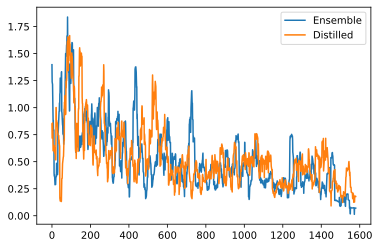

In [149]:
x_train, y_train, _, _ = wine_data.create_train_val_split(1)

x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

x_train = (x_train - x_means) / x_stds
y_train = (y_train - y_means) / y_stds

x_tensor = torch.tensor(x_train).float().to(device)

ens_output = prob_ensemble.predict(x_tensor)
mu_ens = ens_output[:, :, 0]
var_ens = ens_output[:, :, 1]
mean_mu_ens = torch.mean(mu_ens, dim=1).reshape(y_train.shape).cpu().detach().numpy()

ale_ens, epi_ens = metrics.uncertainty_separation_parametric(mu_ens, var_ens)
ale_ens = ale_ens.detach().numpy()
epi_ens = epi_ens.detach().numpy()

z_mean, z_var = distilled_model.forward(x_tensor);
z_mean = z_mean.cpu().detach()
z_var = z_var.cpu().detach().numpy()
mu_dist = z_mean[:, 0].reshape(y_train.shape).numpy()
ale_dist = torch.log(1 + torch.exp(z_mean[:, 1])).numpy()
epi_dist = z_var[:, 1]

dist_spread = z_var.sum(1)

_, ax = plt.subplots()
window_size = 20
uncert_ens = ale_ens + epi_ens
utils.plot_error_curve(ax,
                 y_true=y_train,
                 y_pred=mean_mu_ens,
                 uncert_meas=uncert_ens,
                 window_size=window_size,
                 label="Ensemble")

uncert_dist = ale_dist + epi_dist
utils.plot_error_curve(ax,
                 y_true=y_train,
                 y_pred=mu_dist,
                 uncert_meas=uncert_dist,
                 window_size=window_size,
                 label="Distilled")
ax.legend()
tikzplotlib.save("fig/uci/wine_data_error_ord.tikz")

In [126]:
hidden_size = 50
distilled_output_size = 4
layer_sizes = [wine_data.input_dim, hidden_size, hidden_size, distilled_output_size]
distilled_model = logits_probability_distribution.LogitsProbabilityDistribution(
    layer_sizes=layer_sizes,
    teacher=prob_ensemble,
    variance_transform=utils.variance_linear_asymptote(),
    device=device,
    learning_rate=args.lr)

x_train, y_train, x_test, y_test = wine_data.create_train_val_split(0.9)
x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

x_train = (x_train - x_means) / x_stds
y_train = (y_train - y_means) / y_stds

x_test = (x_test - x_means) / x_stds
y_test = (y_test - y_means) / y_stds

unlabelled_loader = uci_base.uci_dataloader(x_train, y_train, 32)
test_loader = uci_base.uci_dataloader(x_test, y_test, len(y_test))

distilled_model.train(unlabelled_loader, 30)


2020-02-14 14:44:12,102 WARNING LogitsProbabilityDistribution - Must assign proper loss function to child.loss.
2020-02-14 14:44:12,103 INFO  LogitsProbabilityDistribution - Moving model to device: cuda
2020-02-14 14:44:12,119 INFO  LogitsProbabilityDistribution - Training distilled network.
2020-02-14 14:44:17,342 INFO  LogitsProbabilityDistribution - Epoch 1: Loss: 86.66100299358368
2020-02-14 14:44:22,418 INFO  LogitsProbabilityDistribution - Epoch 2: Loss: 51.2422559261322
2020-02-14 14:44:27,329 INFO  LogitsProbabilityDistribution - Epoch 3: Loss: 33.93515337072313
2020-02-14 14:44:32,268 INFO  LogitsProbabilityDistribution - Epoch 4: Loss: 26.08206306397915
2020-02-14 14:44:37,256 INFO  LogitsProbabilityDistribution - Epoch 5: Loss: 18.32106564019341
2020-02-14 14:44:42,224 INFO  LogitsProbabilityDistribution - Epoch 6: Loss: 15.163596290163696
2020-02-14 14:44:47,234 INFO  LogitsProbabilityDistribution - Epoch 7: Loss: 11.977673315443099
2020-02-14 14:44:52,392 INFO  LogitsProba

In [128]:
new_lr = args.lr / 10
distilled_model.learning_rate = new_lr
distilled_model.train(unlabelled_loader, 30)


2020-02-14 14:49:07,222 INFO  LogitsProbabilityDistribution - Training distilled network.
2020-02-14 14:49:12,422 INFO  LogitsProbabilityDistribution - Epoch 1: Loss: 7.797232749173418
2020-02-14 14:49:17,461 INFO  LogitsProbabilityDistribution - Epoch 2: Loss: 8.68631995934993
2020-02-14 14:49:22,513 INFO  LogitsProbabilityDistribution - Epoch 3: Loss: 9.237899657338858
2020-02-14 14:49:27,645 INFO  LogitsProbabilityDistribution - Epoch 4: Loss: 6.121197672560811
2020-02-14 14:49:32,738 INFO  LogitsProbabilityDistribution - Epoch 5: Loss: 6.794786068145186
2020-02-14 14:49:37,863 INFO  LogitsProbabilityDistribution - Epoch 6: Loss: 5.5438367347233
2020-02-14 14:49:43,015 INFO  LogitsProbabilityDistribution - Epoch 7: Loss: 6.472812361083925
2020-02-14 14:49:48,082 INFO  LogitsProbabilityDistribution - Epoch 8: Loss: 5.947049997746944
2020-02-14 14:49:53,161 INFO  LogitsProbabilityDistribution - Epoch 9: Loss: 5.696107182651758
2020-02-14 14:49:58,180 INFO  LogitsProbabilityDistributio

In [129]:
x_train, y_train, x_test, y_test = wine_data.create_train_val_split(0.9)
x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

x_train = (x_train - x_means) / x_stds
y_train = (y_train - y_means) / y_stds

x_test = (x_test - x_means) / x_stds
y_test = (y_test - y_means) / y_stds

single_rmse = metrics.Metric(name="RMSE", function=metrics.root_mean_squared_error)
single_rmse.reset()
single_model = prob_ensemble.members[0]
unlabelled_loader = uci_base.uci_dataloader(x_train, y_train, 32)
test_loader = uci_base.uci_dataloader(x_test, y_test, len(y_test))
for batch in test_loader:
    with torch.no_grad():
        x, y = batch
        x, y = x.float().to(device), y.float().to(device)
        dist_output = distilled_model(x)
        ens_output = prob_ensemble.predict(x)
        #single_model(x)
metrik, _ = single_model.test(test_loader,
                              [single_rmse],
                              custom_loss.gaussian_neg_log_likelihood_1d)
single_rmse = metrik[0]
dist_mean = dist_output[0][:, 0].reshape((len(y_test),))
ens_1_mean = single_model.transform_logits(single_model.forward(x))[0]


targets = torch.tensor(y_test).float().to(device).reshape((len(y_test), 1, 1))
dist_rmse = metrics.Metric(name="RMSE", function=metrics.root_mean_squared_error)
dist_rmse.reset()
dist_rmse.update(targets, dist_mean)
single_rmse.mean() * y_stds[0]
#dist_rmse.mean()* y_stds[0]


0.6786357499934248

(160,)

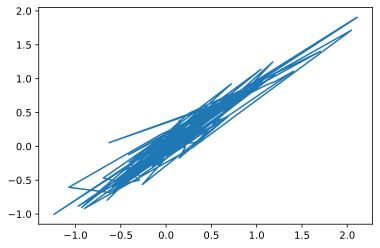

In [ ]:
x, y = wine_data.data[:10, :-1], wine_data.data[:10, -1:]
x = (x - x_means) / x_stds
x = torch.tensor(x, requires_grad=False).float().to(device)
dist_mean, dist_var = distilled_model.forward(x)
preds = prob_ensemble.predict(x)
ens_preds = list()
for pred in preds:
    mean, var = pred[:, 0], pred[:, 1]
    ens_preds.append((mean, var))
    
print(dist_mean)
print(ens_preds[0][0])

# Housing dataset

In [ ]:
bost_data = bost.BostonData("data/uci/bost/housing.data")
train_mc_dropout(data=bost_data,
                 num_epochs=40,
                 num_units=50,
                 learn_rate=1e-4,
                 weight_decay=0.0, #1e-1/len(data)**0.5,
                 train_metrics=train_metrics,
                 test_metrics=test_metrics,
                 batch_size=None)

In [ ]:
for batch in unlabelled_loader:
    x, y = batch
    x, y = x.float().to(device), y.float().to(device)
    logits = distilled_model(x)
    output = distilled_model.transform_logits(logits)
    break
output

In [142]:
hidden_size = 50
distilled_output_size = 4
layer_sizes = [wine_data.input_dim, hidden_size, hidden_size, distilled_output_size]
niw_dist = niw_probability_distribution.Model(layer_sizes=layer_sizes,
                                              teacher=prob_ensemble,
                                              device=device,
                                              learning_rate=args.lr)

x_train, y_train, x_test, y_test = wine_data.create_train_val_split(0.9)
x_means, x_stds = x_train.mean(axis = 0), x_train.var(axis = 0)**0.5
y_means, y_stds = y_train.mean(axis = 0), y_train.var(axis = 0)**0.5

x_train = (x_train - x_means) / x_stds
y_train = (y_train - y_means) / y_stds

x_test = (x_test - x_means) / x_stds
y_test = (y_test - y_means) / y_stds

unlabelled_loader = uci_base.uci_dataloader(x_train, y_train, 32)
test_loader = uci_base.uci_dataloader(x_test, y_test, len(y_test))

niw_dist.train(unlabelled_loader, 30)

2020-02-16 16:01:07,299 WARNING Model           - Must assign proper loss function to child.loss.
2020-02-16 16:01:07,300 INFO  Model           - Moving model to device: cuda
2020-02-16 16:01:07,318 INFO  Model           - Training distilled network.


TypeError: can't assign a tuple to a torch.FloatTensor